In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
import tensorflow_addons as tfa
import pickle


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### parameters

In [5]:
dataset = "fmnist"
labels_per_class = 4 # 'full'
n_latent_dims = 1024
confidence_threshold = 0.0 # minimum confidence to include in UMAP graph for learned metric
learned_metric = True # whether to use a learned metric, or Euclidean distance between datapoints

augmented = True #
min_dist= 0.001 # min_dist parameter for UMAP
negative_sample_rate = 5 # how many negative samples per positive sample 
batch_size = 128 # batch size 
optimizer = tf.keras.optimizers.Adam(1e-3) # the optimizer to train
optimizer = tfa.optimizers.MovingAverage(optimizer)
label_smoothing = 0.2 # how much label smoothing to apply to categorical crossentropy
max_umap_iterations = 500 # how many times, maximum, to recompute UMAP
max_epochs_per_graph = 10 # how many epochs maximum each graph trains for (without early stopping)
graph_patience = 10 # how many times without improvement to train a new graph
min_graph_delta = 0.0025 # minimum improvement on validation acc to consider an improvement for training

In [6]:
from datetime import datetime

datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(confidence_threshold)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_umap_augmented'
)
print(datestring)

fmnist_0.0_4____2020_08_26_22_47_34_287435_umap_augmented


#### Load dataset

In [7]:
from tfumap.semisupervised_keras import load_dataset

In [8]:
(
    X_train,
    X_test,
    X_labeled,
    Y_labeled,
    Y_masked,
    X_valid,
    Y_train,
    Y_test,
    Y_valid,
    Y_valid_one_hot,
    Y_labeled_one_hot,
    num_classes,
    dims
) = load_dataset(dataset, labels_per_class)

### load architecture

In [9]:
from tfumap.semisupervised_keras import load_architecture

In [10]:
encoder, classifier, embedder = load_architecture(dataset, n_latent_dims)

### load pretrained weights

In [11]:
from tfumap.semisupervised_keras import load_pretrained_weights

In [12]:
encoder, classifier = load_pretrained_weights(dataset, augmented, labels_per_class, encoder, classifier)

W0826 22:47:40.065344 140029571331904 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f59ec32f0f0> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f59ec32f588>).
W0826 22:47:40.067353 140029571331904 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f59ec341710> and <tensorflow.python.keras.layers.advanced_activations.

W0826 22:47:40.204296 140029571331904 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f59f7f9e898> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f59f7f9eba8>).
W0826 22:47:40.207258 140029571331904 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f59f7f9eba8> and <tensorflow.python.keras.layers.adv

#### compute pretrained accuracy

In [13]:
# test current acc
pretrained_predictions = classifier.predict(encoder.predict(X_test, verbose=True), verbose=True)
pretrained_predictions = np.argmax(pretrained_predictions, axis=1)
pretrained_acc = np.mean(pretrained_predictions == Y_test)
print('pretrained acc: {}'.format(pretrained_acc))

313/313 [==============================] - 4s 12ms/step
pretrained acc: 0.692


In [14]:
z = encoder.predict(X_train)

In [15]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Aug 26 22:48:28 2020 Finding Nearest Neighbors
Wed Aug 26 22:48:28 2020 Building RP forest with 16 trees
Wed Aug 26 22:48:30 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Wed Aug 26 22:48:41 2020 Finished Nearest Neighbor Search
Wed Aug 26 22:48:44 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Aug 26 22:49:22 2020 Finished embedding


In [17]:
classifications = classifier.predict(z)

In [18]:
class_labels = np.argmax(classifications, axis=1)
confidence = np.max(classifications, axis=1)

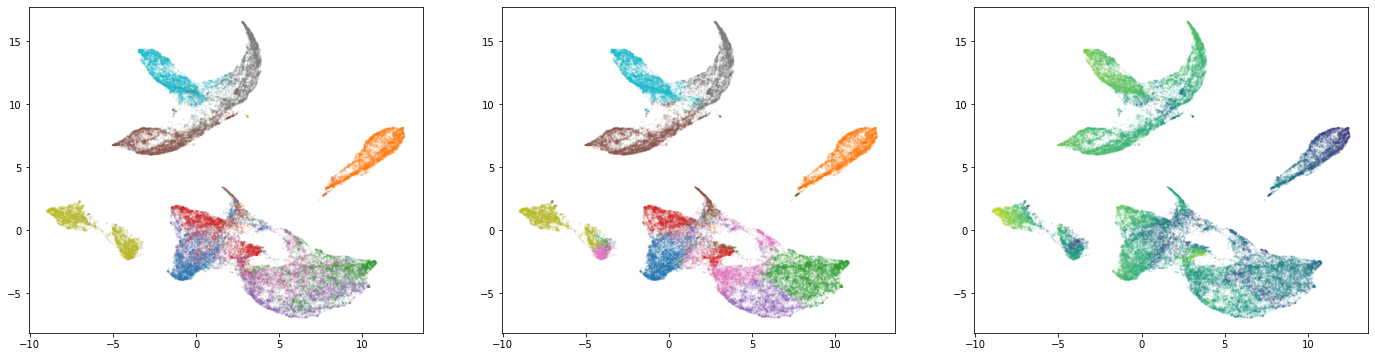

In [22]:
fig, axs = plt.subplots(ncols=3, figsize=(24, 6))
axs[0].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=Y_train.flatten(),
    s=1,
    alpha=0.1,
    cmap=plt.cm.tab10,
)
axs[1].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=class_labels.flatten(),
    s=1,
    alpha=0.1,
    cmap=plt.cm.tab10,
)
axs[2].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=confidence.flatten(),
    s=1,
    alpha=0.1,
    cmap=plt.cm.viridis,
)